### **Color Deconvolution**
#### Color deconvolution is a technique that utilizes the color profiles of stains, such as hematoxylin or diaminobenzidine, to digitally separate these stains from a color image. This process is useful for isolating elements like nuclei or positively stained structures, enhancing tasks such as quantification or image analysis, including segmentation. The provided examples demonstrate how to apply HistomicsTK for color deconvolution, whether using predefined static color profiles or adaptive ones.


In [1]:
from __future__ import print_function

import histomicstk as htk

import numpy as np

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

### **Load input image**
#### The color deconvolution routines in HistomicsTK work with RGB images, which are represented as NxMx3 or 3xN arrays in Numpy's ndarray format.

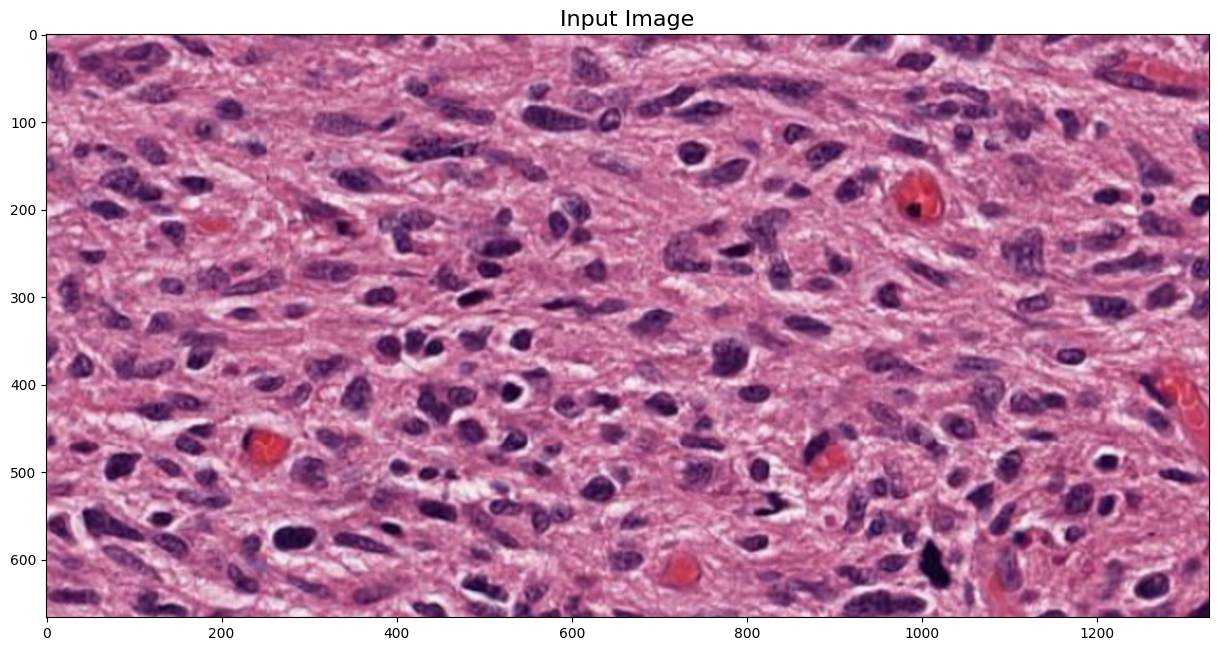

In [2]:
inputImageFile = ('https://data.kitware.com/api/v1/file/'
                  '57802ac38d777f12682731a2/download')  # H&E.png

imInput = skimage.io.imread(inputImageFile)[:, :, :3]

plt.imshow(imInput)
_ = plt.title('Input Image', fontsize=16)

### **Supervised color deconvolution with a known stain matrix**
#### If you already know the stain matrix for color deconvolution, you can easily compute the deconvolved image by using the `color_deconvolution` function found in `histomicstk.preprocessing.color_deconvolution`. This function takes an RGB image and the stain matrix as inputs and returns a namedtuple containing the fields `Stains`, `StainsFloat`, and `Wc`.

#### In this process, the built-in `stain_color_map` dictionary provides reference values to populate the stain matrix. For images with only two stains, it's logical to set the third stain vector perpendicular to the first two, and the `color_deconvolution` function automatically handles this if the third column is all zeros.

stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}


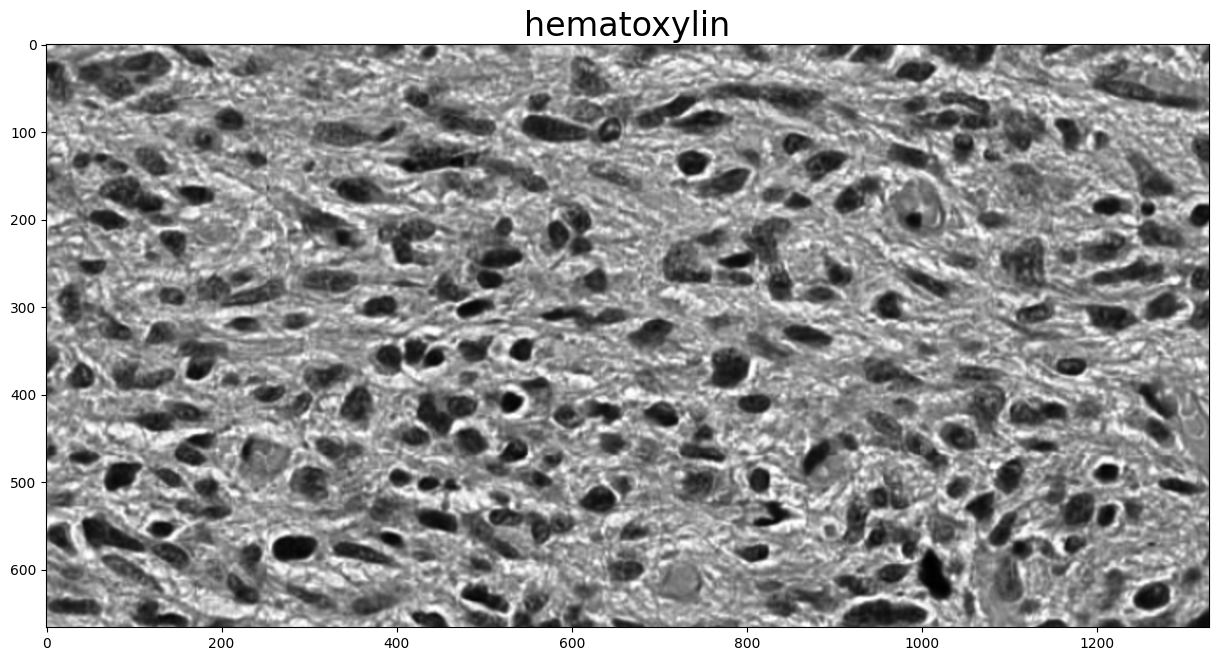

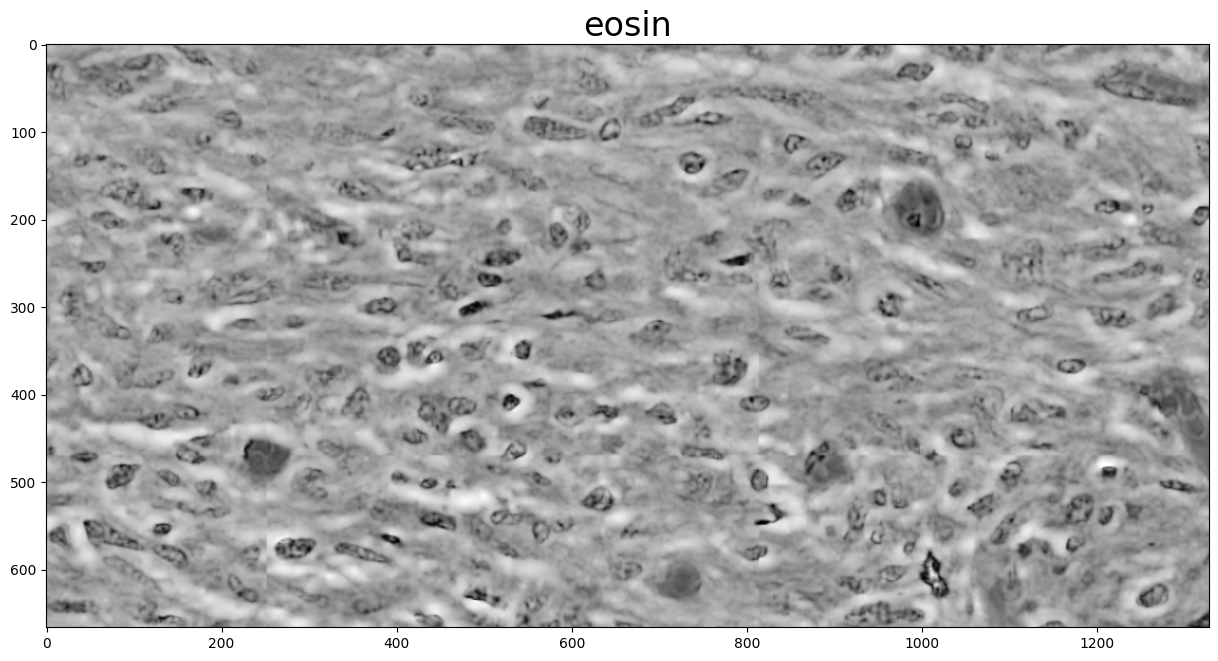

In [3]:
# create stain to color map
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

# perform standard color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, W)

# Display results
for i in 0, 1:
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)

### **Unsupervised Color Deconvolution: Sparse Non-Negative Matrix Factorization**
#### HistomicsTK offers methods to automatically determine stain vectors, with one approach using Sparse Non-Negative Matrix Factorization (SNMF). This method estimates stain vectors based on an initial guess. Applying color deconvolution with these methods involves two steps: first, calculating the stain vectors using one of the `(rgb_)separate_stains_*` functions in `histomicstk.preprocessing.color_deconvolution`, and second, applying these vectors to the image using the `color_deconvolution` function.
#### This example also utilizes a non-RGB-prefixed stain-separation function, which requires the image to be in logarithmic SDA space. Conversion to SDA space is performed using the `rgb_to_sda` function in `histomicstk.preprocessing.color_conversion`. The conversion is parameterized by the image's background intensity, denoted as `I_0`. In this case, `I_0` is set to 255 (full white, applied uniformly across all channels) since there is no background in the image. If background is present, it can be estimated using the `background_intensity` function in `histomicstk.preprocessing.color_normalization`.

Estimated stain colors (in rows):
[[3.66219204e-01 8.08441973e-01 4.60765745e-01]
 [1.07882264e-16 1.00000000e+00 1.07882264e-16]]


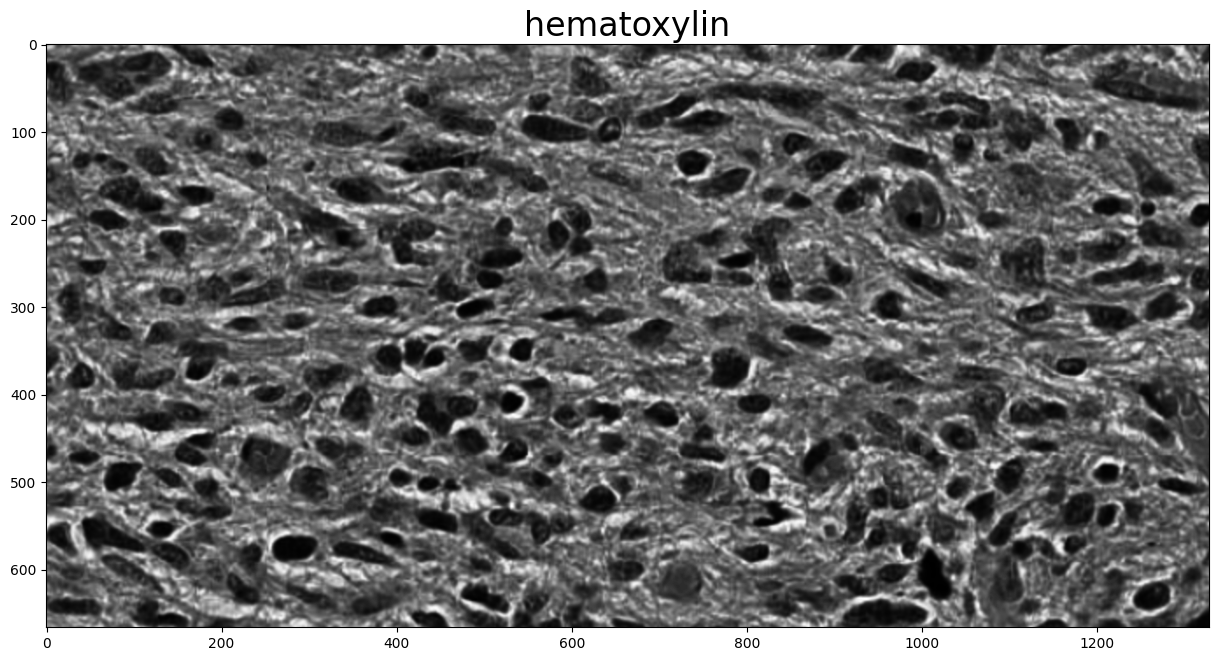

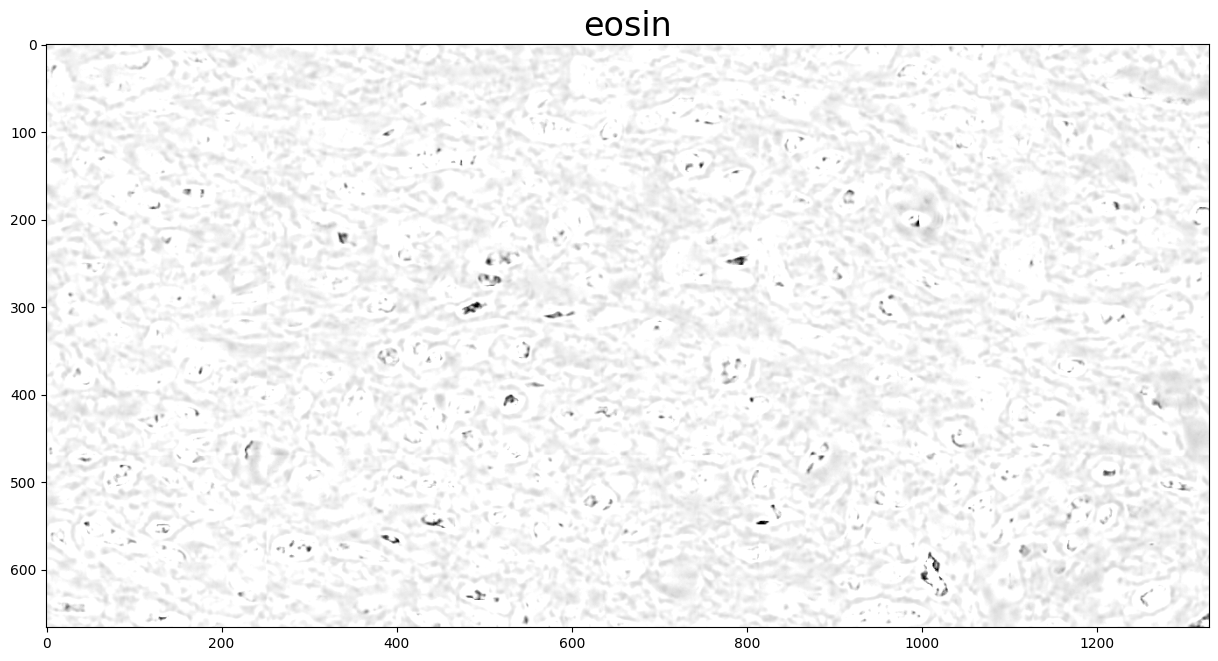

In [4]:
# create initial stain matrix
W_init = W[:, :2]

# Compute stain matrix adaptively
sparsity_factor = 0.5

I_0 = 255
im_sda = htk.preprocessing.color_conversion.rgb_to_sda(imInput, I_0)
W_est = htk.preprocessing.color_deconvolution.separate_stains_xu_snmf(
    im_sda, W_init, sparsity_factor,
)

# perform sparse color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(
    imInput,
    htk.preprocessing.color_deconvolution.complement_stain_matrix(W_est),
    I_0,
)

print('Estimated stain colors (in rows):', W_est.T, sep='\n')

# Display results
for i in 0, 1:
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)

### **PCA-Based Method of Macenko et al.**
#### The PCA-based method, as implemented by Macenko et al., can be used with the rgb_separate_stains_* functions in HistomicsTK. Unlike the SNMF-based approach, this method does not require an initial guess for the stain vectors. Instead, it automatically determines the vectors for a two-stain image during the call, including the conversion to SDA space.

#### Since the process is fully automated, the order of the stain vector columns in the output can be arbitrary. To identify which column corresponds to which stain, you can use the find_stain_index function in histomicstk.preprocessing.color_deconvolution. This function finds the column in the color deconvolution matrix that is closest to a given reference vector.

Estimated stain colors (rows):
[[0.20883651 0.90879498 0.36121877]
 [0.43580308 0.75254732 0.49370862]]


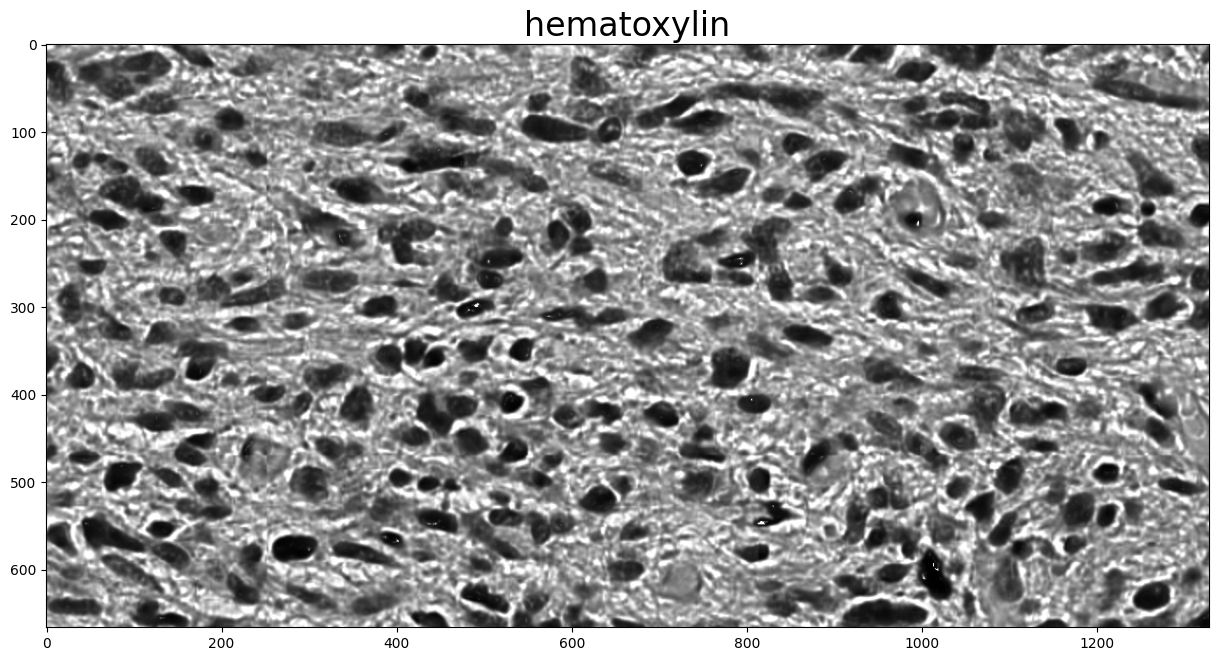

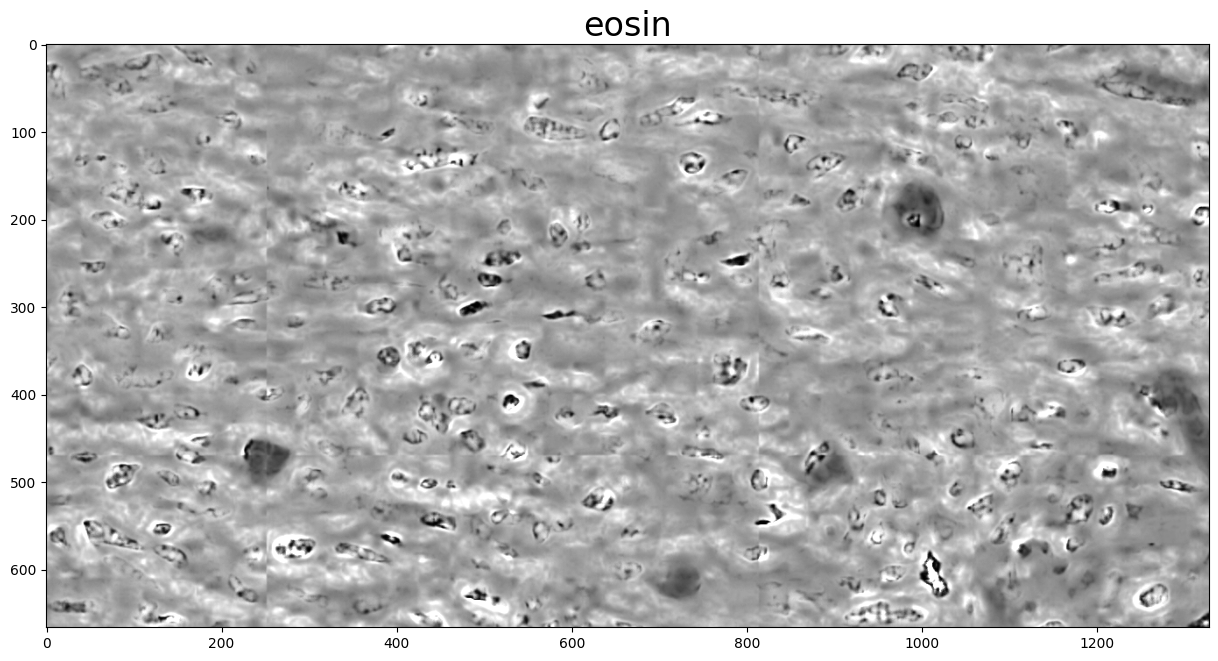

In [5]:
w_est = htk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(imInput, I_0)

# Perform color deconvolution
deconv_result = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, w_est, I_0)

print('Estimated stain colors (rows):', w_est.T[:2], sep='\n')

# Display results
for i in 0, 1:
    plt.figure()
    # Unlike SNMF, we're not guaranteed the order of the different stains.
    # find_stain_index guesses which one we want
    channel = htk.preprocessing.color_deconvolution.find_stain_index(
        stain_color_map[stains[i]], w_est)
    plt.imshow(deconv_result.Stains[:, :, channel])
    _ = plt.title(stains[i], fontsize=titlesize)